# Reccurent Neural Network for Quarterly Financials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm

## Import Financial Data

In [2]:
datadir = 'Income_SP500/'
filelist = os.listdir(datadir)

In [3]:
feats=['TotalRevenue', 'OperatingRevenue', 'PretaxIncome', 'NetIncomeCommonStockholders', 'NetIncome', 'NetIncomeIncludingNoncontrollingInterests', 'NetIncomeContinuousOperations', 'DilutedNIAvailtoComStockholders', 'NetIncomeFromContinuingAndDiscontinuedOperation', 'NormalizedIncome', 'ReconciledDepreciation', 'NetIncomeFromContinuingOperationNetMinorityInterest', 'TaxRateForCalcs', 'TaxEffectOfUnusualItems']
companies=[]
data=np.empty((len(filelist),len(feats)),dtype=object)
for it,filename in enumerate(filelist):
    companies.append(filename.split('_')[0])
    with open(datadir+filename, 'r') as cfile:
        for line in cfile:
            line=[num.replace(',','') for num in line.strip().split('\"') if num.replace(',','') != '']
            if line[0] in feats:
                data[it][feats.index(line[0])]=np.array([float(num) for num in line[1:]])

## Examine Data

In [26]:
def trim_time(company):
	'''
	Trim Company data down to shortest property length
	'''
	shortest_len = min([len(prop) for prop in company])
	
	trimmed_data = np.array([prop[:shortest_len] for prop in company])
	return trimmed_data

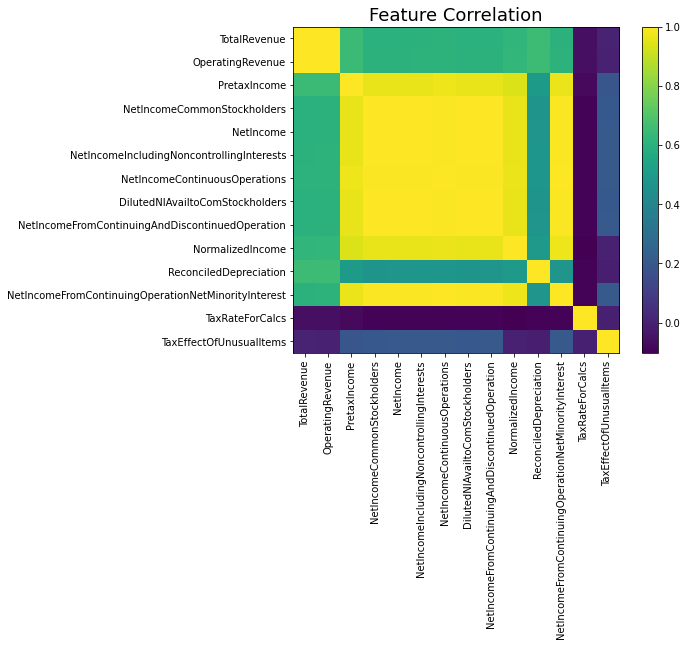

In [49]:
# Concatenate all company data to see feature correlations
prop_data = []

for company in data:
	trim_i = trim_time(company)
	prop_data.append(trim_i)

prop_data = np.concatenate(prop_data, axis=1)

corr = np.corrcoef(prop_data)
plt.figure(figsize=(8,6))
plt.imshow(corr)
plt.colorbar()
plt.title("Feature Correlation", fontsize=18)
plt.xticks(np.arange(14), labels=feats, rotation='vertical')
plt.yticks(np.arange(14), labels=feats)
plt.show()


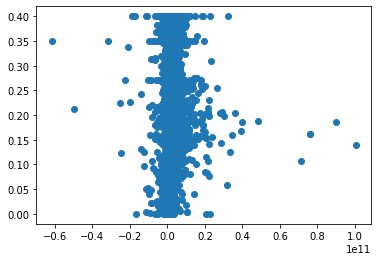

In [54]:
plt.figure()
plt.scatter(prop_data[11], prop_data[12])
plt.show()

## Data Loader for Quarterly Financial Information
 - Will assume continuity of limited time series data for now

## Recurrent Neural Network

In [6]:
if torch.cuda.is_available():
    DEVICE= torch.device('cuda')
else:   
    DEVICE = torch.device('cpu')
print(DEVICE)

class FinRNN(nn.Module):
    def __init__(self, n_features):
        super(FinRNN, self).__init__()
        self.hidden1 = 100
        self.hidden2 = 100

        self.rnn = nn.RNN(n_features, self.hidden1, nonlinearity='relu', batch_first=True)
        self.FC1 = nn.Linear(self.hidden1, self.hidden2)
        self.FC2 = nn.Linear(self.hidden2, 1)
        
    def forward(self, x):
        x, hout = self.rnn(x)
        # Take final RNN output and feed to Fully Connected Layers
        x = self.FC1(x[:, -1, :])
        x = torch.relu(x)
        x = self.FC2(x)
        return x

model = FinRNN(14)
print('# of Parameters:', sum([param.numel() for param in model.parameters()]))

indata = torch.randn(7, 4, 14)

# h0 = torch.randn(2, 3, 20)
output = model(indata)
print(indata.size())
print(output.size())
print(output)

cpu
# of Parameters: 21801
torch.Size([7, 4, 14])
torch.Size([7, 1])
tensor([[0.0429],
        [0.0478],
        [0.0639],
        [0.0808],
        [0.0763],
        [0.0625],
        [0.0652]], grad_fn=<AddmmBackward0>)


In [28]:
print(next(model.parameters()).size())

torch.Size([100, 14])
